In [1]:
# # # Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install astropy

In [21]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# This example imports functions from the DemoReadSGLXData module to read
# digital data. The metadata file must be present in the same directory as the binary file.
# Works with both imec and nidq digital channels.
import numpy as np
from numpy import nan
import cv2 as cv
print(cv.__version__)
import matplotlib.pyplot as plt
import matplotlib as mpl

4.10.0


In [22]:
# This example imports functions from the DemoReadSGLXData module to read
# digital data. The metadata file must be present in the same directory as the binary file.
# Works with both imec and nidq digital channels.

import pandas as pd
import seaborn as sns
from pathlib import Path
import dill as pickle
import samplerate
import multiprocess
import multiprocessing
from astropy.convolution import convolve
import xarray as xr
from tqdm import tqdm

import os

mpl.rcParams['pdf.fonttype'] = 42 
mpl.rcParams['font.sans-serif']=['Arial', 'Helvetica','Bitstream Vera Sans', 'DejaVu Sans', 'Lucida Grande', 
                                 'Verdana', 'Geneva', 'Lucid', 'Avant Garde', 'sans-serif']  

# for publication quality plots
def set_pub_plots(pal=sns.blend_palette(["gray","crimson", 'cyan', 'magenta', 'purple'  ],5)):
    sns.set_style("white")
    sns.set_palette(pal)
    sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2.5, "axes.linewidth":2.5, 'figure.facecolor': 'white'}) 
    sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
    # optional, makes markers bigger, too, axes.linewidth doesn't seem to work
    plt.rcParams['axes.linewidth'] = 2.5

rc_pub={'font.size': 25, 'axes.labelsize': 25, 'legend.fontsize': 25.0, 
    'axes.titlesize': 25, 'xtick.labelsize': 25, 'ytick.labelsize': 25, 
    #'axes.color_cycle':pal, # image.cmap - rewritesd the default colormap
    'axes.linewidth':2.5, 'lines.linewidth': 2.5,
    'xtick.color': 'black', 'ytick.color': 'black', 'axes.edgecolor': 'black','axes.labelcolor':'black','text.color':'black'}
# to restore the defaults, call plt.rcdefaults() 

#set_pub_bargraphs()
set_pub_plots()
sns.set_context('poster')
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

sns.set_context('poster')

In [23]:
# 0)  Paths  ––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
video_path   = r'/Volumes/server3/Data/Mice/VR/Alex/DATA_CHRONIC/ATN/JA178/08_24_22/Eye/JA178_h2_TS6-HF2022-08-24T13_33_27.avi'         # not used here but kept for completeness
dlc_path     = r'/Volumes/server3/Data/Mice/VR/Stella/Labeled_eye_videos/Good_eye_vid_mice/JA178_h2_TS6-HF2022-08-24T13_33_27DLC_resnet50_Pupil_v12Oct17shuffle1_1000000.h5'
  # or .h5
out_path     = r'/Volumes/server3/Data/Mice/VR/Stella/Eye_angles_csv/JA178_eyeAngles.csv'

In [150]:
# 1)  Imports  –––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
import numpy as np
import pandas as pd
import cv2                                  # only if you want to play the video
from pathlib import Path

import matplotlib.pyplot as plt
from scipy.signal      import medfilt
from scipy.interpolate import interp1d
from scipy             import signal   # for FFT resample if you need it later

# sampling rates
fps        = 30.0      # eye-camera frame-rate  (Hz)
unity_rate = 50.0      # Unity behavioural log  (Hz)


In [340]:
#load pupil TTL CSV  → ttl_sq  (0/1 per frame)
eye_ttl_csv = r'/Volumes/server3/Data/Mice/VR/Alex/DATA_CHRONIC/ATN/JA178/08_24_22/Eye/JA178_h2_TS6-HF2022-08-24T13_33_27.csv'     # change to your file
ttl_raw  = pd.read_csv(eye_ttl_csv, header=None).values.ravel()
ttl_filt = medfilt(ttl_raw, 5)                           # remove 1-frame glitches
thr      = 0.5 * (ttl_filt.min() + ttl_filt.max())       # mid-point threshold
ttl_sq   = (ttl_filt > thr).astype(int)                  # perfect 0 / 1
t_eye    = np.arange(len(ttl_sq)) / fps                  # timestamp per frame (s)


In [335]:
# -----------------------------------------------------------------
h5_path = dlc_path   

# -----------------------------------------------------------------
# 1)  Peek inside the HDF5 container – usually only one key
with pd.HDFStore(h5_path, mode='r') as store:
    print('Datasets in file:', store.keys())          # e.g. ['/df_with_missing']

# 2)  Load that dataset (most often 'df_with_missing')
df = pd.read_hdf(h5_path, key='df_with_missing')      # change key if needed

# 3)  The columns are a 3‑level MultiIndex: (scorer, bodypart, coord)
print('\nColumn levels:', df.columns.names)

bodyparts = df.columns.get_level_values(1).unique()
coords    = df.columns.get_level_values(2).unique()

print('\nAvailable body‑part labels:')
for bp in bodyparts:
    print('  •', bp)

print('\nCoordinate channels:', list(coords))   # usually ['x', 'y', 'likelihood']

# Optional: look at the first few rows
display(df.head())

Datasets in file: ['/df_with_missing']

Column levels: ['scorer', 'bodyparts', 'coords']

Available body‑part labels:
  • north
  • ne
  • east
  • se
  • south
  • sw
  • west
  • nw
  • ledge
  • redge
  • tedge
  • bedge

Coordinate channels: ['x', 'y', 'likelihood']


scorer    DLC_resnet50_Pupil_v12Oct17shuffle1_1000000                        \
bodyparts                                       north                         
coords                                              x          y likelihood   
0                                           73.337135  57.757393        1.0   
1                                           74.546967  56.884895        1.0   
2                                           79.146469  54.417645        1.0   
3                                           79.262428  54.184448        1.0   
4                                           79.304298  53.971474        1.0   

scorer                                                                       \
bodyparts         ne                             east                         
coords             x          y likelihood          x          y likelihood   
0          81.342026  57.336010        1.0  84.005356  62.621731        1.0   
1          82.036903  56.255268        1.0  85.848763  61.838783        1.0   
2          86.674347  55.676334        1.0  91.448372  61.988255        1.0   
3          87.208092  55.029263        1.0  92.046547  62.043465        1.0   
4          87.044388  55.227711        1.0  92.104919  62.082386        1.0   

scorer                ...                                               \
bodyparts         se  ...      ledge       redge                         
coords             x  ... likelihood           x          y likelihood   
0          80.761917  ...        1.0  114.358109  58.531761   0.999963   
1          83.651329  ...        1.0  114.113724  56.637249   0.999980   
2          87.039070  ...        1.0  115.047348  57.308739   0.999999   
3          87.389557  ...        1.0  115.487526  57.846352   1.000000   
4          87.680092  ...        1.0  115.208183  57.734447   1.000000   

scorer                                                                       
bodyparts      tedge                            bedge                        
coords             x          y likelihood          x          y likelihood  
0          66.291756  28.551493   1.000000  67.572800  89.021088        1.0  
1          66.459816  28.011559   1.000000  68.545166  88.500763        1.0  
2          68.430565  28.196018   1.000000  70.562744  88.280777        1.0  
3          68.778793  28.094004   0.999999  72.038177  88.450134        1.0  
4          68.775581  28.106152   0.999999  71.100212  88.626839        1.0  

[5 rows x 36 columns]

In [336]:

# Eyeball radius (phys.) in millimetres  –– mouse ≈ 1.7 mm
EYE_RADIUS_MM = 1.7

# Landmark column names exactly as in your DLC/SLEAP export
LABELS_PUPIL = ['north', 'ne', 'east', 'se', 'south', 'sw', 'west', 'nw']
LABELS_EYE   = ['ledge', 'redge', 'tedge', 'bedge'] 

# ---------------------------------------------------------------------------
# 3)  Load landmark table  –––––––––––––––––––––––––––––––––––––––––––––––––––
def load_dlc_table(fname: str) -> pd.DataFrame:
    if fname.endswith('.csv'):
        df = pd.read_csv(fname, header=[0,1,2], index_col=0)
    elif fname.endswith('.h5'):
        df = pd.read_hdf(fname)
    else:
        raise ValueError('Unsupported file type')
    # Flatten the multi‑index:  (bodypart, coord, scorer) → "bodypart_coord"
    df.columns = ['_'.join(col[:2]) for col in df.columns]
    return df

df = load_dlc_table(dlc_path)


In [337]:
import re
import pandas as pd
import numpy as np

# ------------------------------------------------------------------
h5_path = dlc_path  

# 1)  Which datasets live in this file?
with pd.HDFStore(h5_path, 'r') as store:
    print('Keys in HDF5 file:', store.keys())
# DLC usually writes '/df_with_missing'
key = '/df_with_missing'

# 2)  Load that table
df = pd.read_hdf(h5_path, key=key)

# ------------------------------------------------------------------
# 3)  Ensure columns are in the simple form  "<bodypart>_<coord>"
if isinstance(df.columns, pd.MultiIndex):
    # Standard DLC 3‑level format: (scorer, bodypart, coords)
    df.columns = [f'{part}_{coord}' for (_, part, coord) in df.columns]
else:
    # Already strings – strip everything before the body‑part name
    def strip_prefix(col):
        # keep the last two fields separated by '_'  (e.g. north_x)
        m = re.search(r'([^_]+_[xy]|likelihood)$', col)
        return m.group(0) if m else col
    df.columns = [strip_prefix(c) for c in df.columns]

print('First few flattened column names:', df.columns[:36].tolist())

Keys in HDF5 file: ['/df_with_missing']
First few flattened column names: ['north_x', 'north_y', 'north_likelihood', 'ne_x', 'ne_y', 'ne_likelihood', 'east_x', 'east_y', 'east_likelihood', 'se_x', 'se_y', 'se_likelihood', 'south_x', 'south_y', 'south_likelihood', 'sw_x', 'sw_y', 'sw_likelihood', 'west_x', 'west_y', 'west_likelihood', 'nw_x', 'nw_y', 'nw_likelihood', 'ledge_x', 'ledge_y', 'ledge_likelihood', 'redge_x', 'redge_y', 'redge_likelihood', 'tedge_x', 'tedge_y', 'tedge_likelihood', 'bedge_x', 'bedge_y', 'bedge_likelihood']


In [338]:
# convenience helpers
def xy_arrays(labels):
    """Return Nx2 array of (x,y) for all frames for the given label list."""
    xs = df[[f'{lb}_x' for lb in labels]].values
    ys = df[[f'{lb}_y' for lb in labels]].values
    return np.stack([xs, ys], axis=-1)      # shape = (frame, label, xy)

In [341]:
pupil_pts = xy_arrays(LABELS_PUPIL)       # (N, 8, 2)
eye_pts   = xy_arrays(LABELS_EYE)         # (N, 4, 2)

N = pupil_pts.shape[0]
pupil_centers = np.nanmean(pupil_pts, axis=1)     # (N, 2)

# --- Fit circle to the 4 eye‑rim points per frame --------------------------
#   Algebraic circle fit (Taubin)  – fast & good enough for 4 pts
eye_centers   = np.empty((N, 2))*np.nan
eye_radii_px  = np.empty(N)*np.nan

for i, pts in enumerate(eye_pts):
    if np.any(np.isnan(pts)):            # blink or missing label
        continue
    x, y = pts[:,0], pts[:,1]
    A = np.column_stack([2*x, 2*y, np.ones_like(x)])
    b = x**2 + y**2
    try:
        c, d, e = np.linalg.lstsq(A, b, rcond=None)[0]
        xc, yc  = c, d
        r_px    = np.sqrt(e + xc**2 + yc**2)
        eye_centers[i]  = [xc, yc]
        eye_radii_px[i] = r_px
    except np.linalg.LinAlgError:
        pass   # leave NaNs

/var/folders/qw/mrrsfmtj5f3257yg203y_5zm0000gq/T/ipykernel_87785/3537516004.py:10: RuntimeWarning: invalid value encountered in multiply
  eye_radii_px  = np.empty(N)*np.nan


In [42]:
import sys, types, pickle, pandas as pd

# -----------------------------------------------------------------
# 1)  Build a stub module that contains a stand-in Int64Index class
fake_numeric = types.ModuleType("pandas.core.indexes.numeric")

class Int64Index(pd.Index):          # minimal shim
    """Back-compat alias for pandas < 2 pickles."""
    pass

fake_numeric.Int64Index = Int64Index
sys.modules["pandas.core.indexes.numeric"] = fake_numeric
# -----------------------------------------------------------------

# 2)  Unpickle
path = r'/Users/stellabanou/Documents/Python_scripts/hfvis_dict.pkl'
with open(path, "rb") as f:
    d_hfdat = pickle.load(f)

print("Dictionary keys:", list(d_hfdat.keys()))


Dictionary keys: ['20220818_JA178_lADN_red_H2_VR1_TS6-HF', '20220819_JA178_lADN_red_H2_VR1_TS6-HF', '20220819_JA178_lADN_red_H2_VR1_TS7-HF', '20220823_JA178_lADN_red_H2_VR1_TS6-HF', '20220823_JA178_lADN_red_H2_VR1_TS7-HF', '20220823_JA178_lADN_red_H2_VR1_TS7-HFLMK', '20220824_JA178_lADN_red_H2_VR1_TS6-HF', '20220824_JA178_lADN_red_H2_VR1_TS6-HFLMK180', '20220824_JA178_lADN_red_H2_VR1_TS7-HF', '20220902_JA178_rADN_yel_H2_VR1_TS6-HF', '20220902_JA178_rADN_yel_H2_VR1_TS7-HF', '20220906_JA178_rADN_yel_H2_VR1_TS6-HF', '20220907_JA178_rADN_yel_H2_VR1_TS6-HF', '20220907_JA178_rADN_yel_H2_VR1_TS7-HF', '20220908_JA178_rADN_yel_H2_VR1_TS6-HF', '20220908_JA178_rADN_yel_H2_VR1_TS6-HFLMK30', '20220908_JA178_rADN_yel_H2_VR1_TS6-VIS', '20220909_JA178_rADN_yel_H2_VR1_TS6-HF', '20220909_JA178_rADN_yel_H2_VR1_TS6-VIS', '20220802_JA179_lADN_red_H2_VR1_TS6-HF', '20220802_JA179_lADN_red_H2_VR1_TS7-HF', '20220803_JA179_lADN_red_H2_VR1_TS6-HF', '20220803_JA179_lADN_red_H2_VR1_TS7-HF', '20220804_JA179_lADN_re

In [153]:
for k, v in d_hfdat.items():
    if hasattr(v, "shape"):
        print(f"{k:>20}  shape={v.shape}  dtype={v.dtype}")
    elif isinstance(v, (list, tuple)):
        print(f"{k:>20}  list len={len(v)}   first={type(v[0]).__name__}")
    else:
        print(f"{k:>20}  type={type(v).__name__}")
sess_key = '20220824_JA178_lADN_red_H2_VR1_TS6-HF'   # <-- edit if needed
sess     = d_hfdat[sess_key]

# 1-B. List columns in the 'unity' DataFrame
unity_df = sess['unity']           # this is the 50 Hz behavioural log
print('Unity columns:\n', list(unity_df.columns))

20220818_JA178_lADN_red_H2_VR1_TS6-HF  type=dict
20220819_JA178_lADN_red_H2_VR1_TS6-HF  type=dict
20220819_JA178_lADN_red_H2_VR1_TS7-HF  type=dict
20220823_JA178_lADN_red_H2_VR1_TS6-HF  type=dict
20220823_JA178_lADN_red_H2_VR1_TS7-HF  type=dict
20220823_JA178_lADN_red_H2_VR1_TS7-HFLMK  type=dict
20220824_JA178_lADN_red_H2_VR1_TS6-HF  type=dict
20220824_JA178_lADN_red_H2_VR1_TS6-HFLMK180  type=dict
20220824_JA178_lADN_red_H2_VR1_TS7-HF  type=dict
20220902_JA178_rADN_yel_H2_VR1_TS6-HF  type=dict
20220902_JA178_rADN_yel_H2_VR1_TS7-HF  type=dict
20220906_JA178_rADN_yel_H2_VR1_TS6-HF  type=dict
20220907_JA178_rADN_yel_H2_VR1_TS6-HF  type=dict
20220907_JA178_rADN_yel_H2_VR1_TS7-HF  type=dict
20220908_JA178_rADN_yel_H2_VR1_TS6-HF  type=dict
20220908_JA178_rADN_yel_H2_VR1_TS6-HFLMK30  type=dict
20220908_JA178_rADN_yel_H2_VR1_TS6-VIS  type=dict
20220909_JA178_rADN_yel_H2_VR1_TS6-HF  type=dict
20220909_JA178_rADN_yel_H2_VR1_TS6-VIS  type=dict
20220802_JA179_lADN_red_H2_VR1_TS6-HF  type=dict
2022

paired eye pulses : 304
paired unity pulses: 304


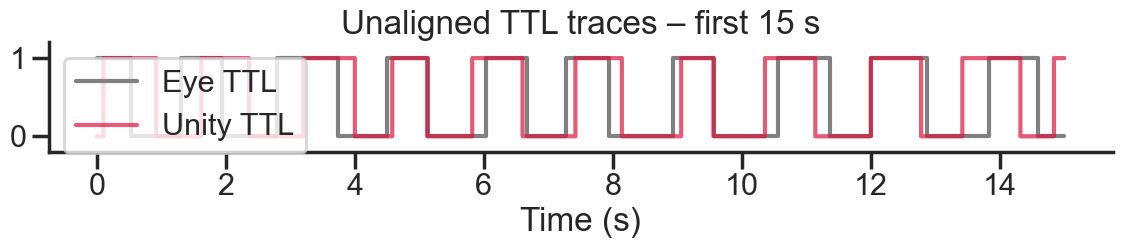

In [342]:
# ------------------------------------------------------------------
# 2-A. Give the exact Unity TTL column name you just spotted
UNITY_TTL_COL = 'TTL'          # <-- replace with your column name

# pupil TTL:  ttl_sq   (0/1 square you built earlier)
t_eye = np.arange(len(ttl_sq)) / fps

# Unity TTL column
unity_ttl  = unity_df[UNITY_TTL_COL].to_numpy()
t_unity    = np.arange(len(unity_ttl)) / unity_rate   # or use time column if present

# ------------------------------------------------------------------
# 2-C. Quick overlay: first 15 s unaligned
import matplotlib.pyplot as plt
end_win = 15                                      # seconds to display
mask_eye   = t_eye   <= end_win
mask_unity = t_unity <= end_win

plt.figure(figsize=(12, 3))
plt.step(t_eye[mask_eye],   ttl_sq[mask_eye],   where='post', label='Eye TTL')
plt.step(t_unity[mask_unity], unity_ttl[mask_unity], where='post',
         label='Unity TTL', alpha=0.7)
plt.ylim(-0.2, 1.2)
plt.xlabel('Time (s)'), plt.title('Unaligned TTL traces – first 15 s')
plt.legend(); plt.tight_layout(); plt.show()


In [343]:
# find coarse lag (seconds) using first 5 min
eye50      = interp1d(t_eye, ttl_sq, kind='nearest')(t_unity)   # upsample eye → 50 Hz
win        = int(5*60*unity_rate)                               # 5 min window
xc         = np.correlate(unity_ttl[:win], eye50[:win], mode='full')
lag_samples= xc.argmax() - (win - 1)          # +ve → unity behind
lag_sec    = lag_samples / unity_rate
print(f'Coarse lag  = {lag_samples:+d} samples  ({lag_sec:+.2f} s)')

t_unity_shift = t_unity + lag_sec             # apply coarse shift


Coarse lag  = -2685 samples  (-53.70 s)


In [344]:
# 1)  Rising edges, after *coarse* shift (no block tweaks)
eye_idx   = np.where(np.diff(ttl_sq.astype(int))   == 1)[0] + 1
unity_idx = np.where(np.diff(unity_ttl.astype(int)) == 1)[0] + 1
eye_t     = eye_idx / fps
unity_t   = t_unity_shift[unity_idx]               # coarse-shifted times

# 2)  Greedy pairing with wide tol
tol = 0.15
i=j=0; pe=[]; pu=[]
while i<len(eye_t) and j<len(unity_t):
    d = unity_t[j]-eye_t[i]
    if abs(d)<=tol: pe.append(eye_t[i]); pu.append(unity_t[j]); i+=1; j+=1
    elif d<0: j+=1
    else: i+=1
pe = np.array(pe); pu = np.array(pu)

# 3)  Fit refined slope+offset
slope2, off2 = np.polyfit(pu, pe, 1)
print('new slope', slope2, 'offset', off2)

t_unity_final = slope2 * t_unity + off2          # <-- NO block tweaks

# 4)  Residual check with tight tol (0.15 s)
res = pe - (slope2*pu + off2)
print('RMS', 1e3*np.sqrt((res**2).mean()), 'ms  max', 1e3*np.max(abs(res)),'ms')


new slope 1.0000701331944155 offset -0.01592618740213018
RMS 80.41815205499077 ms  max 162.0395212682979 ms


In [345]:
# ---------------------------------------------------------------
# 1) Greedy pairing with narrower tolerance  (0.20 s)
tol = 0.2          # 200 ms = 10 Unity samples

pair_eye, pair_uni = [], []
i = j = 0
while i < len(eye_t) and j < len(unity_t):
    dt = unity_t[j] - eye_t[i]
    if abs(dt) <= tol:
        pair_eye.append(eye_t[i]); pair_uni.append(unity_t[j])
        i += 1; j += 1
    elif dt < 0: j += 1
    else:        i += 1

pe = np.asarray(pair_eye)
pu = np.asarray(pair_uni)
print("Pairs with 200 ms tol:", len(pe))

# ---------------------------------------------------------------
# 2) First slope/offset fit
slope1, off1 = np.polyfit(pu, pe, 1)
print("pre-clean  slope", slope1, " offset", off1)

# residuals of first fit
res1 = pe - (slope1 * pu + off1)

# ---------------------------------------------------------------
# 3) Reject outliers > 0.25 s and refit
mask_good = np.abs(res1) < 0.25       # keep well-matched edges
print("Good pairs after clean:", mask_good.sum())

slope2, off2 = np.polyfit(pu[mask_good], pe[mask_good], 1)
print("final slope", slope2, " offset", off2)

t_unity_final = slope2 * t_unity_shift + off2

# ---------------- residual check ----------------
res2 = pe[mask_good] - (slope2 * pu[mask_good] + off2)
print("RMS", 1e3*np.sqrt((res2**2).mean()), "ms  max", 1e3*np.max(np.abs(res2)), "ms")


Pairs with 200 ms tol: 78
pre-clean  slope 1.0001120417944425  offset -0.020274967197253333
Good pairs after clean: 78
final slope 1.0001120417944425  offset -0.020274967197253333
RMS 115.26164639814529 ms  max 220.5147885900942 ms


In [326]:
t_unity_ref = slope1 * t_unity_shift + off1        # uses the 78 correct matches


In [346]:
# ────────────────────────────────────────────────────────────────
# 2)  Pair rising edges using the refined timeline
# ---------------------------------------------------------------
tol = 0.25                          # 250 ms (≈ 12 Unity samples)

eye_idx      = np.where(np.diff(ttl_sq.astype(int))   == 1)[0] + 1
unity_idx    = np.where(np.diff(unity_ttl.astype(int)) == 1)[0] + 1

eye_t        = eye_idx / fps                  # seconds
unity_t_ref  = t_unity_ref[unity_idx]         # seconds

pair_eye, pair_uni = [], []
i = j = 0
while i < len(eye_t) and j < len(unity_t_ref):
    dt = unity_t_ref[j] - eye_t[i]
    if abs(dt) <= tol:                       # good match
        pair_eye.append(eye_t[i])
        pair_uni.append(unity_t_ref[j])
        i += 1; j += 1                       # advance BOTH lists
    elif dt < 0:                             # Unity pulse earlier → advance Unity
        j += 1
    else:                                    # Eye pulse earlier  → advance eye
        i += 1

pair_eye = np.asarray(pair_eye)
pair_uni = np.asarray(pair_uni)
print(f'Paired pulses with ±{tol*1000:.0f} ms tol: {len(pair_eye)}  '
      f'of {min(len(eye_idx), len(unity_idx))} expected')


Paired pulses with ±250 ms tol: 96  of 354 expected


In [347]:
# 3)  Final slope + offset  (should hardly change)
slope2, off2 = np.polyfit(pair_uni, pair_eye, 1)
print('final slope', slope2, '  offset', off2)

t_unity_final = slope2 * t_unity_shift + off2      # ultimate timeline

# 4)  Residual check
res = pair_eye - (slope2 * pair_uni + off2)
print("Residual RMS = %.3f ms   max = %.3f ms"
      % (1e3*np.sqrt((res**2).mean()), 1e3*np.max(np.abs(res))))


final slope 1.0000890779762175   offset -0.012213730191060413
Residual RMS = 143.488 ms   max = 262.262 ms


In [348]:
# detect rising edges & pair them with ±0.8 s tolerance
eye_idx   = np.where(np.diff(ttl_sq)==1)[0] + 1
unity_idx = np.where(np.diff(unity_ttl)==1)[0] + 1

eye_t   = eye_idx / fps
unity_t = t_unity_final[unity_idx]

tol_wide = 0.8                                # seconds
pair_eye = []; pair_uni = []
i=j=0
while i<len(eye_t) and j<len(unity_t):
    dt = unity_t[j]-eye_t[i]
    if abs(dt)<=tol_wide:
        pair_eye.append(eye_t[i]); pair_uni.append(unity_t[j]); i+=1; j+=1
    elif dt<0: j+=1
    else:      i+=1

pair_eye = np.asarray(pair_eye)
pair_uni = np.asarray(pair_uni)
print("Wide-tol pairs:", len(pair_eye))


Wide-tol pairs: 296


In [349]:
# refine alignment with linear fit
slope, offset = np.polyfit(pair_uni, pair_eye, 1)
print(f'slope = {slope:.8f}   offset = {offset:+.4f} s')

t_unity_ref = slope * t_unity_shift + offset


slope = 1.00023752   offset = -0.0835 s


In [350]:
# pair edges again with ±0.15 s, compute residuals
unity_t_ref_edges = t_unity_final[unity_idx]

pair_eye=[]; pair_uni=[]
tol_tight = 0.15
i=j=0
while i<len(eye_t) and j<len(unity_t_ref_edges):
    dt = unity_t_ref_edges[j]-eye_t[i]
    if abs(dt)<=tol_tight:
        pair_eye.append(eye_t[i]); pair_uni.append(unity_t_ref_edges[j]); i+=1; j+=1
    elif dt<0: j+=1
    else:      i+=1

res = np.asarray(pair_eye) - np.asarray(pair_uni)
print("Tight residuals –  RMS %.2f ms  max %.2f ms"
      % (1e3*np.sqrt((res**2).mean()), 1e3*np.max(np.abs(res))))


Tight residuals –  RMS 79.24 ms  max 147.52 ms


In [332]:
# integer-sample block-by-block correction
block_len_s   = 5
samples_per_block = int(block_len_s*unity_rate)
search_radius = 30          # ±10 samples (±200 ms)
eye_to_50 = interp1d(
    t_eye,            # 0 … 624 s
    ttl_sq,           # 0/1 per frame
    kind='nearest',
    bounds_error=False,
    fill_value=0      # LED definitely off outside video range
)

ttl_eye50 = eye_to_50(t_unity_ref)

shift_trace = np.zeros(len(unity_ttl), dtype=int)
cum_shift   = 0
for b in range(len(unity_ttl)//samples_per_block):
    u0,u1 = b*samples_per_block,(b+1)*samples_per_block
    e0,e1 = u0+cum_shift, u0+cum_shift+samples_per_block
    if e1 > len(ttl_eye50): break
    cc = np.correlate(unity_ttl[u0:u1], ttl_eye50[e0:e1], mode='full')
    mid = len(cc)//2
    lag = cc[mid-search_radius:mid+search_radius+1].argmax() - search_radius
    cum_shift += lag
    shift_trace[u1:] += lag

t_unity_block = t_unity_final + shift_trace / unity_rate


FINAL residuals – RMS 88.44 ms  max 147.92 ms


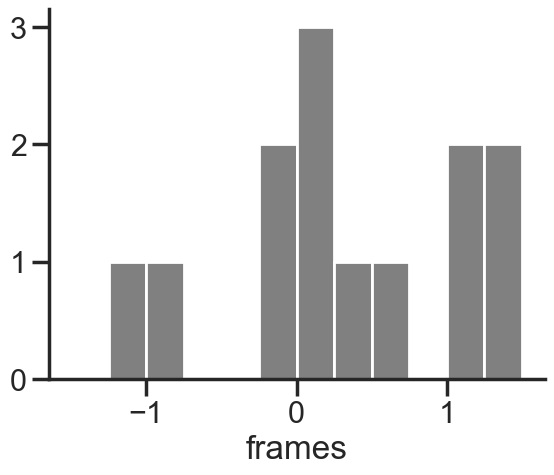

In [333]:
# Cell 9 – re-pair with tight tol using t_unity_block; plot residuals
unity_t_block_edges = t_unity_block[unity_idx]
pair_eye=[]; pair_uni=[]
i=j=0; tol=0.15
while i<len(eye_t) and j<len(unity_t_block_edges):
    dt=unity_t_block_edges[j]-eye_t[i]
    if abs(dt)<=tol: pair_eye.append(eye_t[i]); pair_uni.append(unity_t_block_edges[j]); i+=1; j+=1
    elif dt<0: j+=1
    else: i+=1

res = np.asarray(pair_eye)-np.asarray(pair_uni)
print("FINAL residuals – RMS %.2f ms  max %.2f ms" %
      (1e3*np.sqrt((res**2).mean()), 1e3*np.max(np.abs(res))))
plt.hist(res*fps, bins=np.arange(-1.5,1.6,0.25)); plt.xlabel('frames'); plt.show()


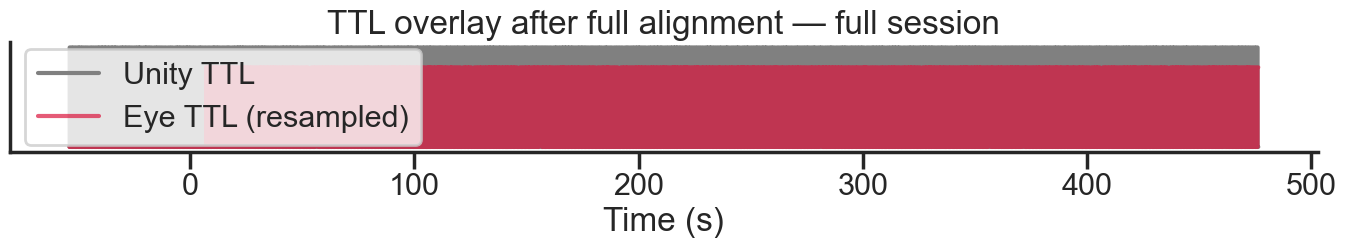

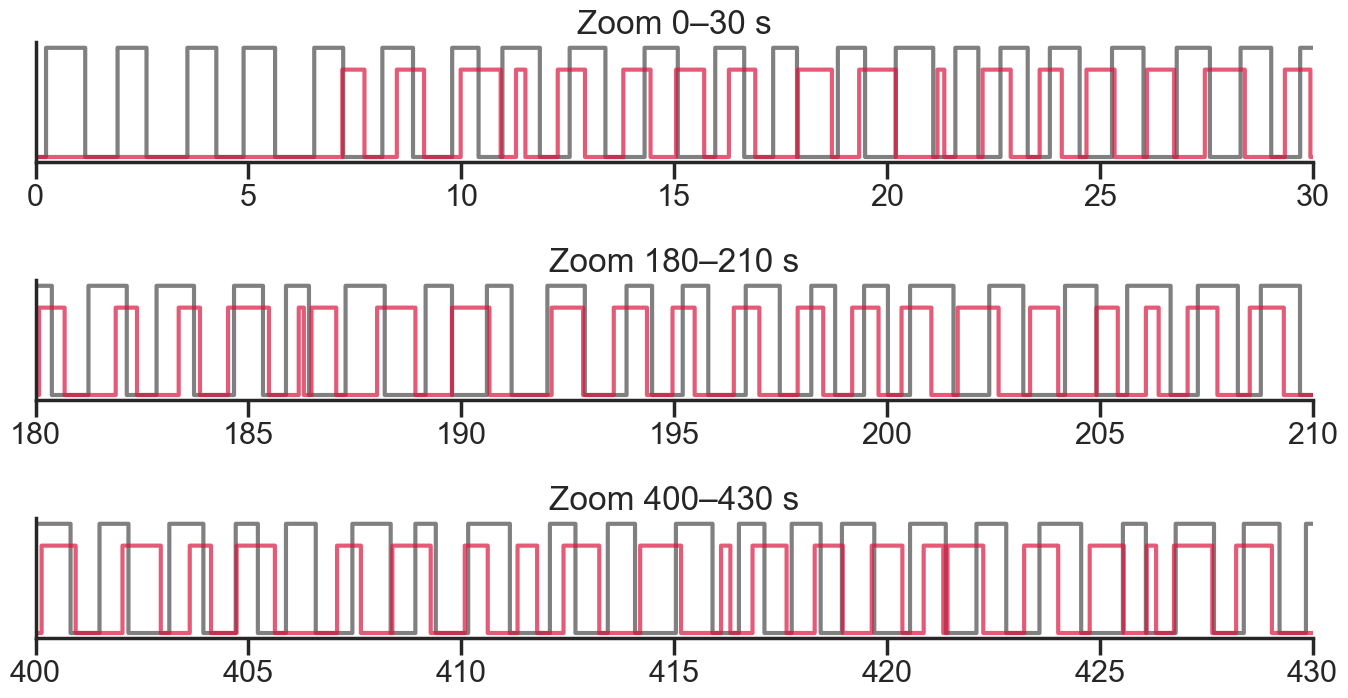

In [351]:
# ────────────────────────────────────────────────────────────────
# 0)  Put eye TTL on the SAME 50 Hz time grid as the corrected Unity timeline
eye_to_50 = interp1d(
    t_eye,            # eye-frame times (s)
    ttl_sq,           # 0/1 per frame
    kind='nearest',
    bounds_error=False,
    fill_value=0
)
ttl_eye50 = eye_to_50(t_unity_block)     # same length & rate as unity_ttl

# ────────────────────────────────────────────────────────────────
# 1)  Overlay the FULL recording
plt.figure(figsize=(14, 3))
plt.step(t_unity_final, unity_ttl,      where='post', label='Unity TTL')
plt.step(t_unity_final, ttl_eye50*0.8, where='post',
         label='Eye TTL (resampled)', alpha=0.7)
plt.yticks([]); plt.xlabel('Time (s)')
plt.title('TTL overlay after full alignment — full session')
plt.legend(); plt.tight_layout(); plt.show()

# ────────────────────────────────────────────────────────────────
# 2)  Zoom-in panels to spot tiny drifts (optional)
zoom_windows = [(0, 30), (180, 210), (400, 430)]   # choose any windows (s)
fig, axes = plt.subplots(len(zoom_windows), 1, figsize=(14, 2.5*len(zoom_windows)))
if len(zoom_windows) == 1: axes = [axes]

for ax, (t0, t1) in zip(axes, zoom_windows):
    mask = (t_unity_final >= t0) & (t_unity_block <= t1)
    ax.step(t_unity_final[mask], unity_ttl[mask], where='post')
    ax.step(t_unity_final[mask], ttl_eye50[mask]*0.8, where='post', alpha=0.7)
    ax.set_xlim(t0, t1); ax.set_yticks([])
    ax.set_title(f'Zoom {t0}–{t1} s')

plt.tight_layout(); plt.show()


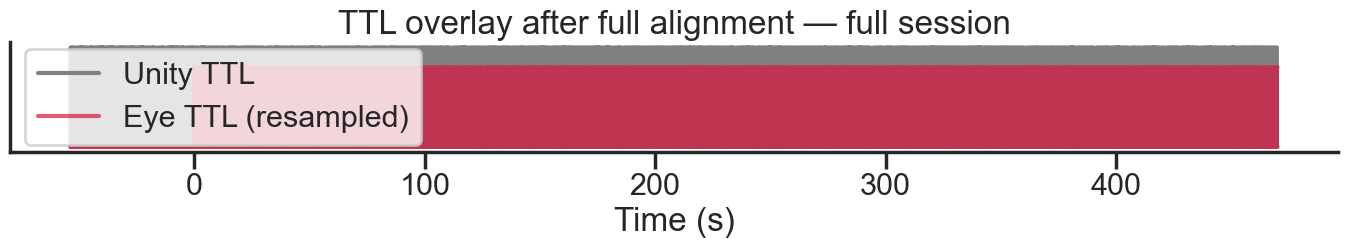

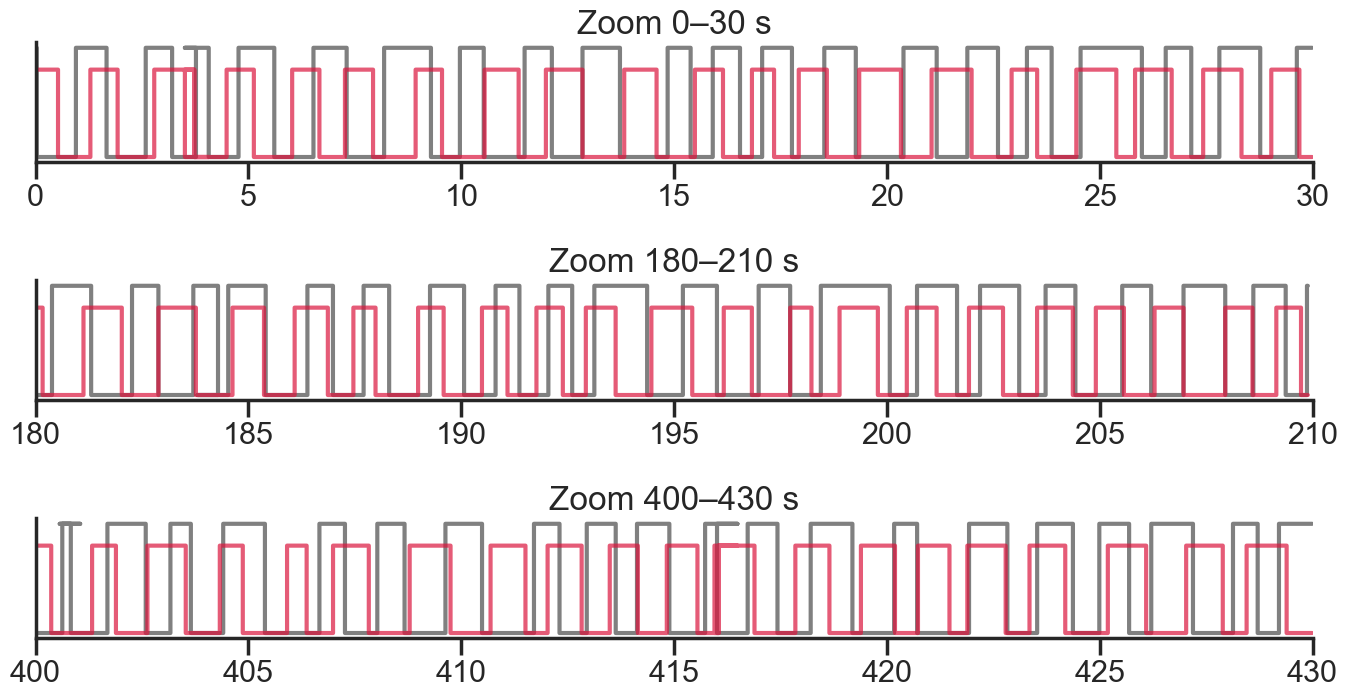

In [352]:
# ────────────────────────────────────────────────────────────────
# 0)  Put eye TTL on the SAME 50 Hz time grid as the corrected Unity timeline
eye_to_50 = interp1d(
    t_eye,            # eye-frame times (s)
    ttl_sq,           # 0/1 per frame
    kind='nearest',
    bounds_error=False,
    fill_value=0
)
ttl_eye50 = eye_to_50(t_unity_block)     # same length & rate as unity_ttl

# ────────────────────────────────────────────────────────────────
# 1)  Overlay the FULL recording
plt.figure(figsize=(14, 3))
plt.step(t_unity_block, unity_ttl,      where='post', label='Unity TTL')
plt.step(t_unity_block, ttl_eye50*0.8, where='post',
         label='Eye TTL (resampled)', alpha=0.7)
plt.yticks([]); plt.xlabel('Time (s)')
plt.title('TTL overlay after full alignment — full session')
plt.legend(); plt.tight_layout(); plt.show()

# ────────────────────────────────────────────────────────────────
# 2)  Zoom-in panels to spot tiny drifts (optional)
zoom_windows = [(0, 30), (180, 210), (400, 430)]   # choose any windows (s)
fig, axes = plt.subplots(len(zoom_windows), 1, figsize=(14, 2.5*len(zoom_windows)))
if len(zoom_windows) == 1: axes = [axes]

for ax, (t0, t1) in zip(axes, zoom_windows):
    mask = (t_unity_block >= t0) & (t_unity_block <= t1)
    ax.step(t_unity_block[mask], unity_ttl[mask], where='post')
    ax.step(t_unity_block[mask], ttl_eye50[mask]*0.8, where='post', alpha=0.7)
    ax.set_xlim(t0, t1); ax.set_yticks([])
    ax.set_title(f'Zoom {t0}–{t1} s')

plt.tight_layout(); plt.show()


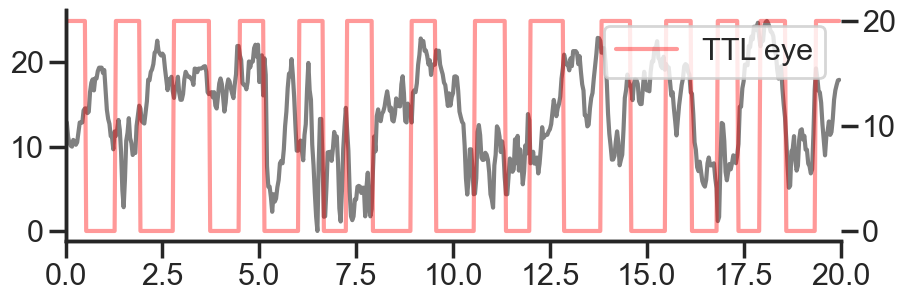

In [255]:
# Cell 10 – example: speed to cm s⁻¹ per eye frame
unity_speed_mps = unity_df['speed'].to_numpy()     # m/s
unity_speed_cm  = unity_speed_mps * 100.0

interp_speed = interp1d(t_unity_block, unity_speed_cm,
                        kind='nearest', bounds_error=False,
                        fill_value='extrapolate')
speed_frame  = interp_speed(t_eye)                 # cm/s, len == len(ttl_sq)

# quick sanity plot (eye vs. speed, first 20 s)
plt.figure(figsize=(10,3))
plt.plot(t_eye[:600], speed_frame[:600], label='speed (cm/s)')
plt.twinx().plot(t_eye[:600], ttl_sq[:600]*20, 'r', alpha=0.4, label='TTL eye')
plt.xlim(0,20); plt.legend(); plt.show()


✓ Saved eye angles → JA178_eyeAngles.csv


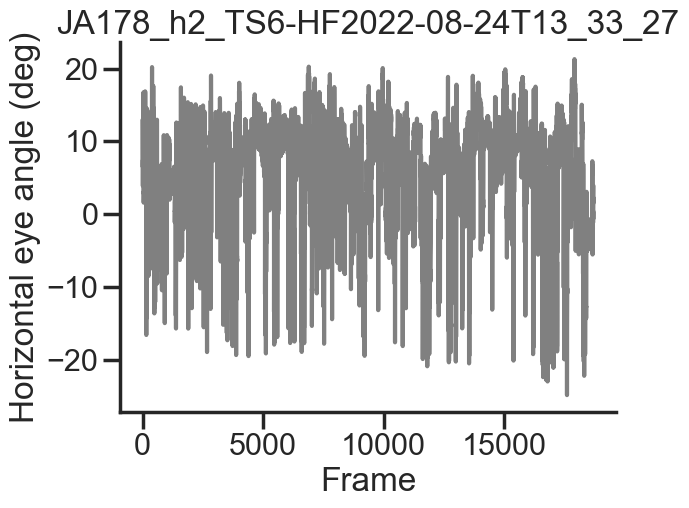

In [225]:
# ---------------------------------------------------------------------------
# 5)  Pixel → mm conversion  ––––––––––––––––––––––––––––––––––––––––––––––––
# Use the median radius to define a single pix→mm factor for the entire video
valid_r = eye_radii_px[~np.isnan(eye_radii_px)]
pix2mm  = EYE_RADIUS_MM / np.nanmedian(valid_r)
# ---------------------------------------------------------------------------
# 6)  Horizontal displacement & angle  ––––––––––––––––––––––––––––––––––––––
dx_px   = pupil_centers[:,0] - eye_centers[:,0]     # (pupil_x − eye_x)
dx_mm   = dx_px * pix2mm

eye_h_rad = np.arcsin(np.clip(dx_mm / EYE_RADIUS_MM, -1, 1))
eye_h_deg = np.degrees(eye_h_rad)

df_out = pd.DataFrame({
    'frame'      : np.arange(N),
    'eye_h_deg'  : eye_h_deg,
    'dx_px'      : dx_px,
    'eye_radius_px' : eye_radii_px,
})

df_out.to_csv(out_path, index=False)
print(f'✓ Saved eye angles → {Path(out_path).name}')

# ---------------------------------------------------------------------------
# 7)  Quick preview plot  –––––––––––––––––––––––––––––––––––––––––––––––––––
import matplotlib.pyplot as plt
plt.plot(df_out['eye_h_deg'])
plt.xlabel('Frame'), plt.ylabel('Horizontal eye angle (deg)')
plt.title(Path(video_path).stem)
plt.show()

In [256]:
# Unity speed is still per-sample at 50 Hz but *times* are corrected
f_speed = interp1d(
    t_unity_block,          # x-axis: corrected times  (seconds)
    unity_speed_cms,        # y-axis: speed values     (cm s⁻¹)
    kind='nearest',         # or 'linear' if you prefer
    bounds_error=False,
    fill_value=(unity_speed_cms[0], unity_speed_cms[-1])
)


In [257]:
speed_frame = f_speed(t_eye) 

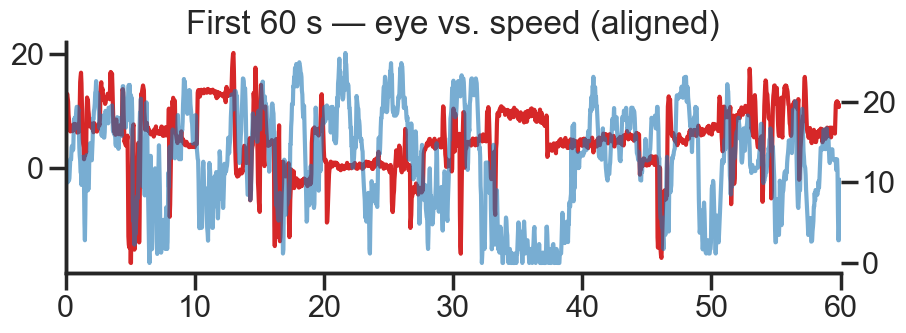

In [258]:
plt.figure(figsize=(10,3))
plt.plot(t_eye[:1800], eye_h_deg[:1800], label='Eye H (°)', color='tab:red')
plt.twinx().plot(t_eye[:1800], speed_frame[:1800],
                 label='Speed (cm/s)', color='tab:blue', alpha=0.6)
plt.xlim(0, 60); plt.xlabel('Time (s)')
plt.title('First 60 s — eye vs. speed (aligned)')
plt.show()

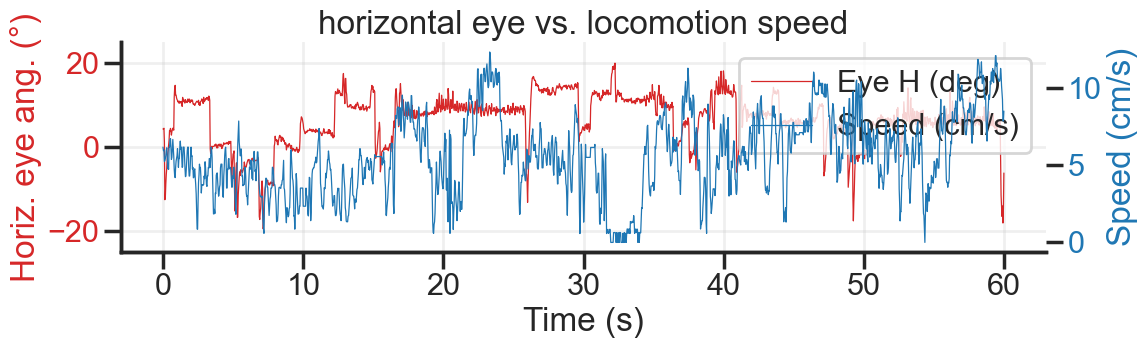

In [365]:
# ────────────────────────────────────────────────────────────────
# 0)  Extract Unity speed, convert to cm/s, and interpolate
from scipy.interpolate import interp1d
import numpy as np, matplotlib.pyplot as plt

# Unity speed column is stored in metres per second
unity_speed_mps = unity_df['speed'].to_numpy()          # m / s
unity_speed_cms = unity_speed_mps * 50.0               # → cm / s

interp_speed = interp1d(
    t_unity_block,              # ← use the block-corrected timestamps
    unity_speed_cms,
    kind='nearest',
    bounds_error=False,
    fill_value=(unity_speed_cms[0], unity_speed_cms[-1])
)
speed_frame = interp_speed(t_eye)   # cm s⁻¹ per eye frame

# ── pick any minute you want to plot ────────────────────────────
minute_num = 5            # 0-based: 0=first minute, 2=third minute

# time window for that minute
start_s = minute_num * 60
end_s   = start_s + 60

mask = (t_eye >= start_s) & (t_eye < end_s)

t_min   = t_eye[mask]         - start_s      # 0-60 s within the minute
eye_min = eye_h_deg[mask]
spd_min = speed_frame[mask]


# ────────────────────────────────────────────────────────────────
# 2)  Plot: horizontal eye (deg) + speed (cm/s)
fig, ax1 = plt.subplots(figsize=(12, 4))

# left axis: eye position
ax1.plot(t_min, eye_min, lw=0.9, color='tab:red', label='Eye H (deg)')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Horiz. eye ang. (°)', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_ylim(-25, 25)
ax1.set_title('horizontal eye vs. locomotion speed')

# right axis: speed
ax2 = ax1.twinx()
ax2.plot(t_min, spd_min, lw=0.9, color='tab:blue', label='Speed (cm/s)')
ax2.set_ylabel('Speed (cm/s)', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# grid, legend
ax1.grid(alpha=0.3)
handles = ax1.get_lines() + ax2.get_lines()
labels  = [h.get_label() for h in handles]
ax1.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.show()


In [230]:
# max / min / mean directly from the Unity log
unity_df['speed'].max() # peak speed


0.3459922473938093

In [233]:
assert t_unity_block[0] <= t_eye[0] and t_unity_block[-1] >= t_eye[-1], \
       "Unity timeline shorter than eye video — trim or extrapolate"


In [232]:
# overlap mask: keep frames from the first to the last Unity time
mask_overlap = (t_eye >= t_unity_block[0]) & (t_eye <= t_unity_block[-1])

t_eye        = t_eye[mask_overlap]
eye_h_deg    = eye_h_deg[mask_overlap]

# rebuild speed_frame after trimming
speed_frame  = interp_speed(t_eye)


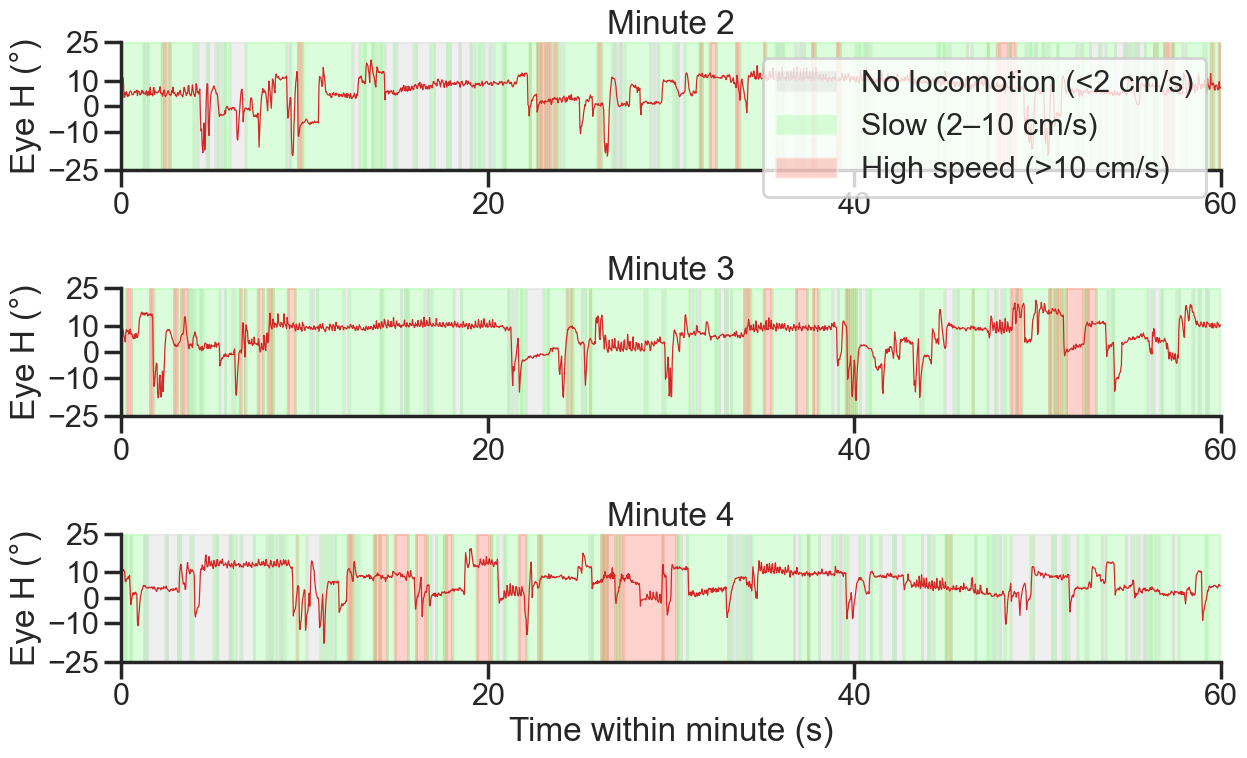

In [366]:
# ────────────────────────────────────────────────────────────────
# 0)  SETTINGS YOU CAN TWEAK
minutes_to_plot = [2, 3, 4]   # 0-based minute numbers
thr_slow_cm  =  5.0      # cm/s  (0-2 → no locomotion)
thr_fast_cm  = 10.0      # cm/s  (2-10 → slow; >10 → high speed)

# colours for shading
COLOR_NONE = 'lightgray'
COLOR_SLOW = 'palegreen'
COLOR_FAST = 'salmon'

# ────────────────────────────────────────────────────────────────
# 1)  BUILD speed_frame (cm/s)  – safe even if it already exists
unity_speed_mps = unity_df['speed'].to_numpy()        # Unity column is m/s
unity_speed_cm  = unity_speed_mps * 50.0             # convert to cm/s

interp_speed = interp1d(
    t_unity_block,              # ← use the block-corrected timestamps
    unity_speed_cms,
    kind='nearest',
    bounds_error=False,
    fill_value=(unity_speed_cms[0], unity_speed_cms[-1])
)
speed_frame = interp_speed(t_eye)   # cm s⁻¹ per eye frame


# ────────────────────────────────────────────────────────────────
# 2)  CLASSIFY each frame
state = np.full_like(speed_frame, 'none', dtype=object)
state[speed_frame >= thr_slow_cm] = 'slow'
state[speed_frame >= thr_fast_cm] = 'fast'

# ────────────────────────────────────────────────────────────────
# 3)  PLOT requested minutes with shaded locomotion states
import numpy as np, matplotlib.pyplot as plt, math

frames_per_min = int(round(fps * 60))
fig_h = 2.7 * len(minutes_to_plot)
fig, axes = plt.subplots(len(minutes_to_plot), 1,
                         figsize=(13, fig_h), sharex=False)

if len(minutes_to_plot) == 1:
    axes = [axes]

for ax, minute in zip(axes, minutes_to_plot):
    f0, f1 = minute * frames_per_min, (minute + 1) * frames_per_min
    t_m    = t_eye[f0:f1] - minute*60      # 0-60 s slice
    eye_m  = eye_h_deg[f0:f1]
    st_m   = state[f0:f1]

    # shade contiguous blocks
    start = 0
    while start < len(st_m):
        block_state = st_m[start]
        end = start
        while end < len(st_m) and st_m[end] == block_state:
            end += 1
        if block_state == 'none':
            color = COLOR_NONE
        elif block_state == 'slow':
            color = COLOR_SLOW
        else:
            color = COLOR_FAST
        ax.axvspan(t_m[start], t_m[end-1], color=color, alpha=0.35)
        start = end

    # eye trace
    ax.plot(t_m, eye_m, lw=0.9, color='tab:red')
    ax.set_ylim(-25, 25)
    ax.set_xlim(0, 60)
    ax.set_xticks([0, 20, 40, 60])
    ax.set_yticks([-25, -10, 0, 10, 25])
    ax.set_ylabel('Eye H (°)')
    ax.set_title(f'Minute {minute}')

axes[-1].set_xlabel('Time within minute (s)')

# legend
from matplotlib.patches import Patch
legend_elems = [Patch(fc=COLOR_NONE,  alpha=0.35, label='No locomotion (<2 cm/s)'),
                Patch(fc=COLOR_SLOW,  alpha=0.35, label='Slow (2–10 cm/s)'),
                Patch(fc=COLOR_FAST,  alpha=0.35, label='High speed (>10 cm/s)')]
axes[0].legend(handles=legend_elems, loc='upper right')

plt.tight_layout()
plt.show()


In [79]:
assert np.allclose(np.diff(t_eye), 1/fps, atol=1e-6), \
       "t_eye isn’t a clean frame grid – check how it’s built!"
print("✓ t_eye spacing = %.6f s (%.4f Hz)" % (t_eye[1]-t_eye[0], 1/(t_eye[1]-t_eye[0])))


✓ t_eye spacing = 0.033333 s (30.0000 Hz)


Residual (eye – unity)  mean = 2539.2447 ms   RMS = 2645.0569 ms   max = 4142.7555 ms


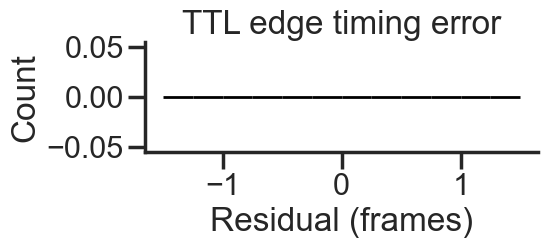

In [353]:
# rising edges (already computed earlier)
eye_edges   = np.where(np.diff(ttl_sq.astype(int))   == 1)[0] + 1
unity_edges = np.where(np.diff(unity_ttl.astype(int)) == 1)[0] + 1

eye_t   = eye_edges / fps
unity_t = unity_edges / unity_rate * slope + offset

n_common = min(len(eye_t), len(unity_t))

residual_s  = eye_t[:n_common] - unity_t[:n_common]
residual_fr = residual_s * fps

print("Residual (eye – unity)  mean = %.4f ms   RMS = %.4f ms   max = %.4f ms"
      % (1e3*residual_s.mean(), 1e3*np.sqrt(np.mean(residual_s**2)), 1e3*np.max(np.abs(residual_s))))

# histogram
import matplotlib.pyplot as plt
plt.figure(figsize=(6,3))
plt.hist(residual_fr, bins=np.arange(-1.5,1.6,0.25), color='gray', edgecolor='k')
plt.xlabel('Residual (frames)'); plt.ylabel('Count')
plt.title('TTL edge timing error')
plt.tight_layout(); plt.show()


In [51]:
import pandas as pd
win = 15                     # ~0.5 s at 30 fps  (adjust as you like)
eye_h_smooth = (
    pd.Series(eye_h_deg)
    .rolling(window=win, center=True, min_periods=1)
    .median()
    .values
)


In [16]:
import cv2, numpy as np, matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# ------------------------------------------------------------------
# 1)  Input arrays --------------------------------------------------
# eye_h_deg  – your horizontal‑angle trace, shape (N,)
# If you followed the earlier steps:
#   eye_h_deg = ...   # already computed
#   video_path = ...  # path to the .mp4

cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
cap.release()
print(f'FPS = {fps:.2f}')

# ------------------------------------------------------------------
# 2)  Build the time axis (s) and slice by minute ------------------
t_sec = np.arange(len(eye_h_deg)) / fps
frames_per_min = int(round(fps * 60))          # integer frames in 60 s
n_panels       = 10                            # show first 10 min

# ------------------------------------------------------------------
# 3)  Plot grid  ----------------------------------------------------
fig, axes = plt.subplots(3, 4, figsize=(45, 25), sharey=True)
axes = axes.ravel()

sec_formatter = FuncFormatter(lambda x, pos: f'{int(x):02d} s')

for i in range(n_panels):
    f0      = i * frames_per_min
    f1      = f0 + frames_per_min
    ax      = axes[i]
    ax.plot(t_sec[f0:f1] - i*60, eye_h_deg[f0:f1])
    ax.set_xlim(0, 60)
    ax.set_xticks([0, 20, 40, 60])
    ax.set_xticklabels(['0', '20', '40', '60'])
    ax.set_title(f'Minute {i+1}', fontsize=34)
    ax.set_ylim(-25, 25)
    ax.set_yticks([-25, -20, -10, 0, 10, 20, 25])

# tidy up
for ax in axes[n_panels:]:
    ax.axis('off')
    ax.grid(True)
fig.suptitle('SB024 Horizontal eye angle – minute segments', fontsize=40)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


FPS = 29.00


NameError: name 'eye_h_deg' is not defined

FPS = 29.00


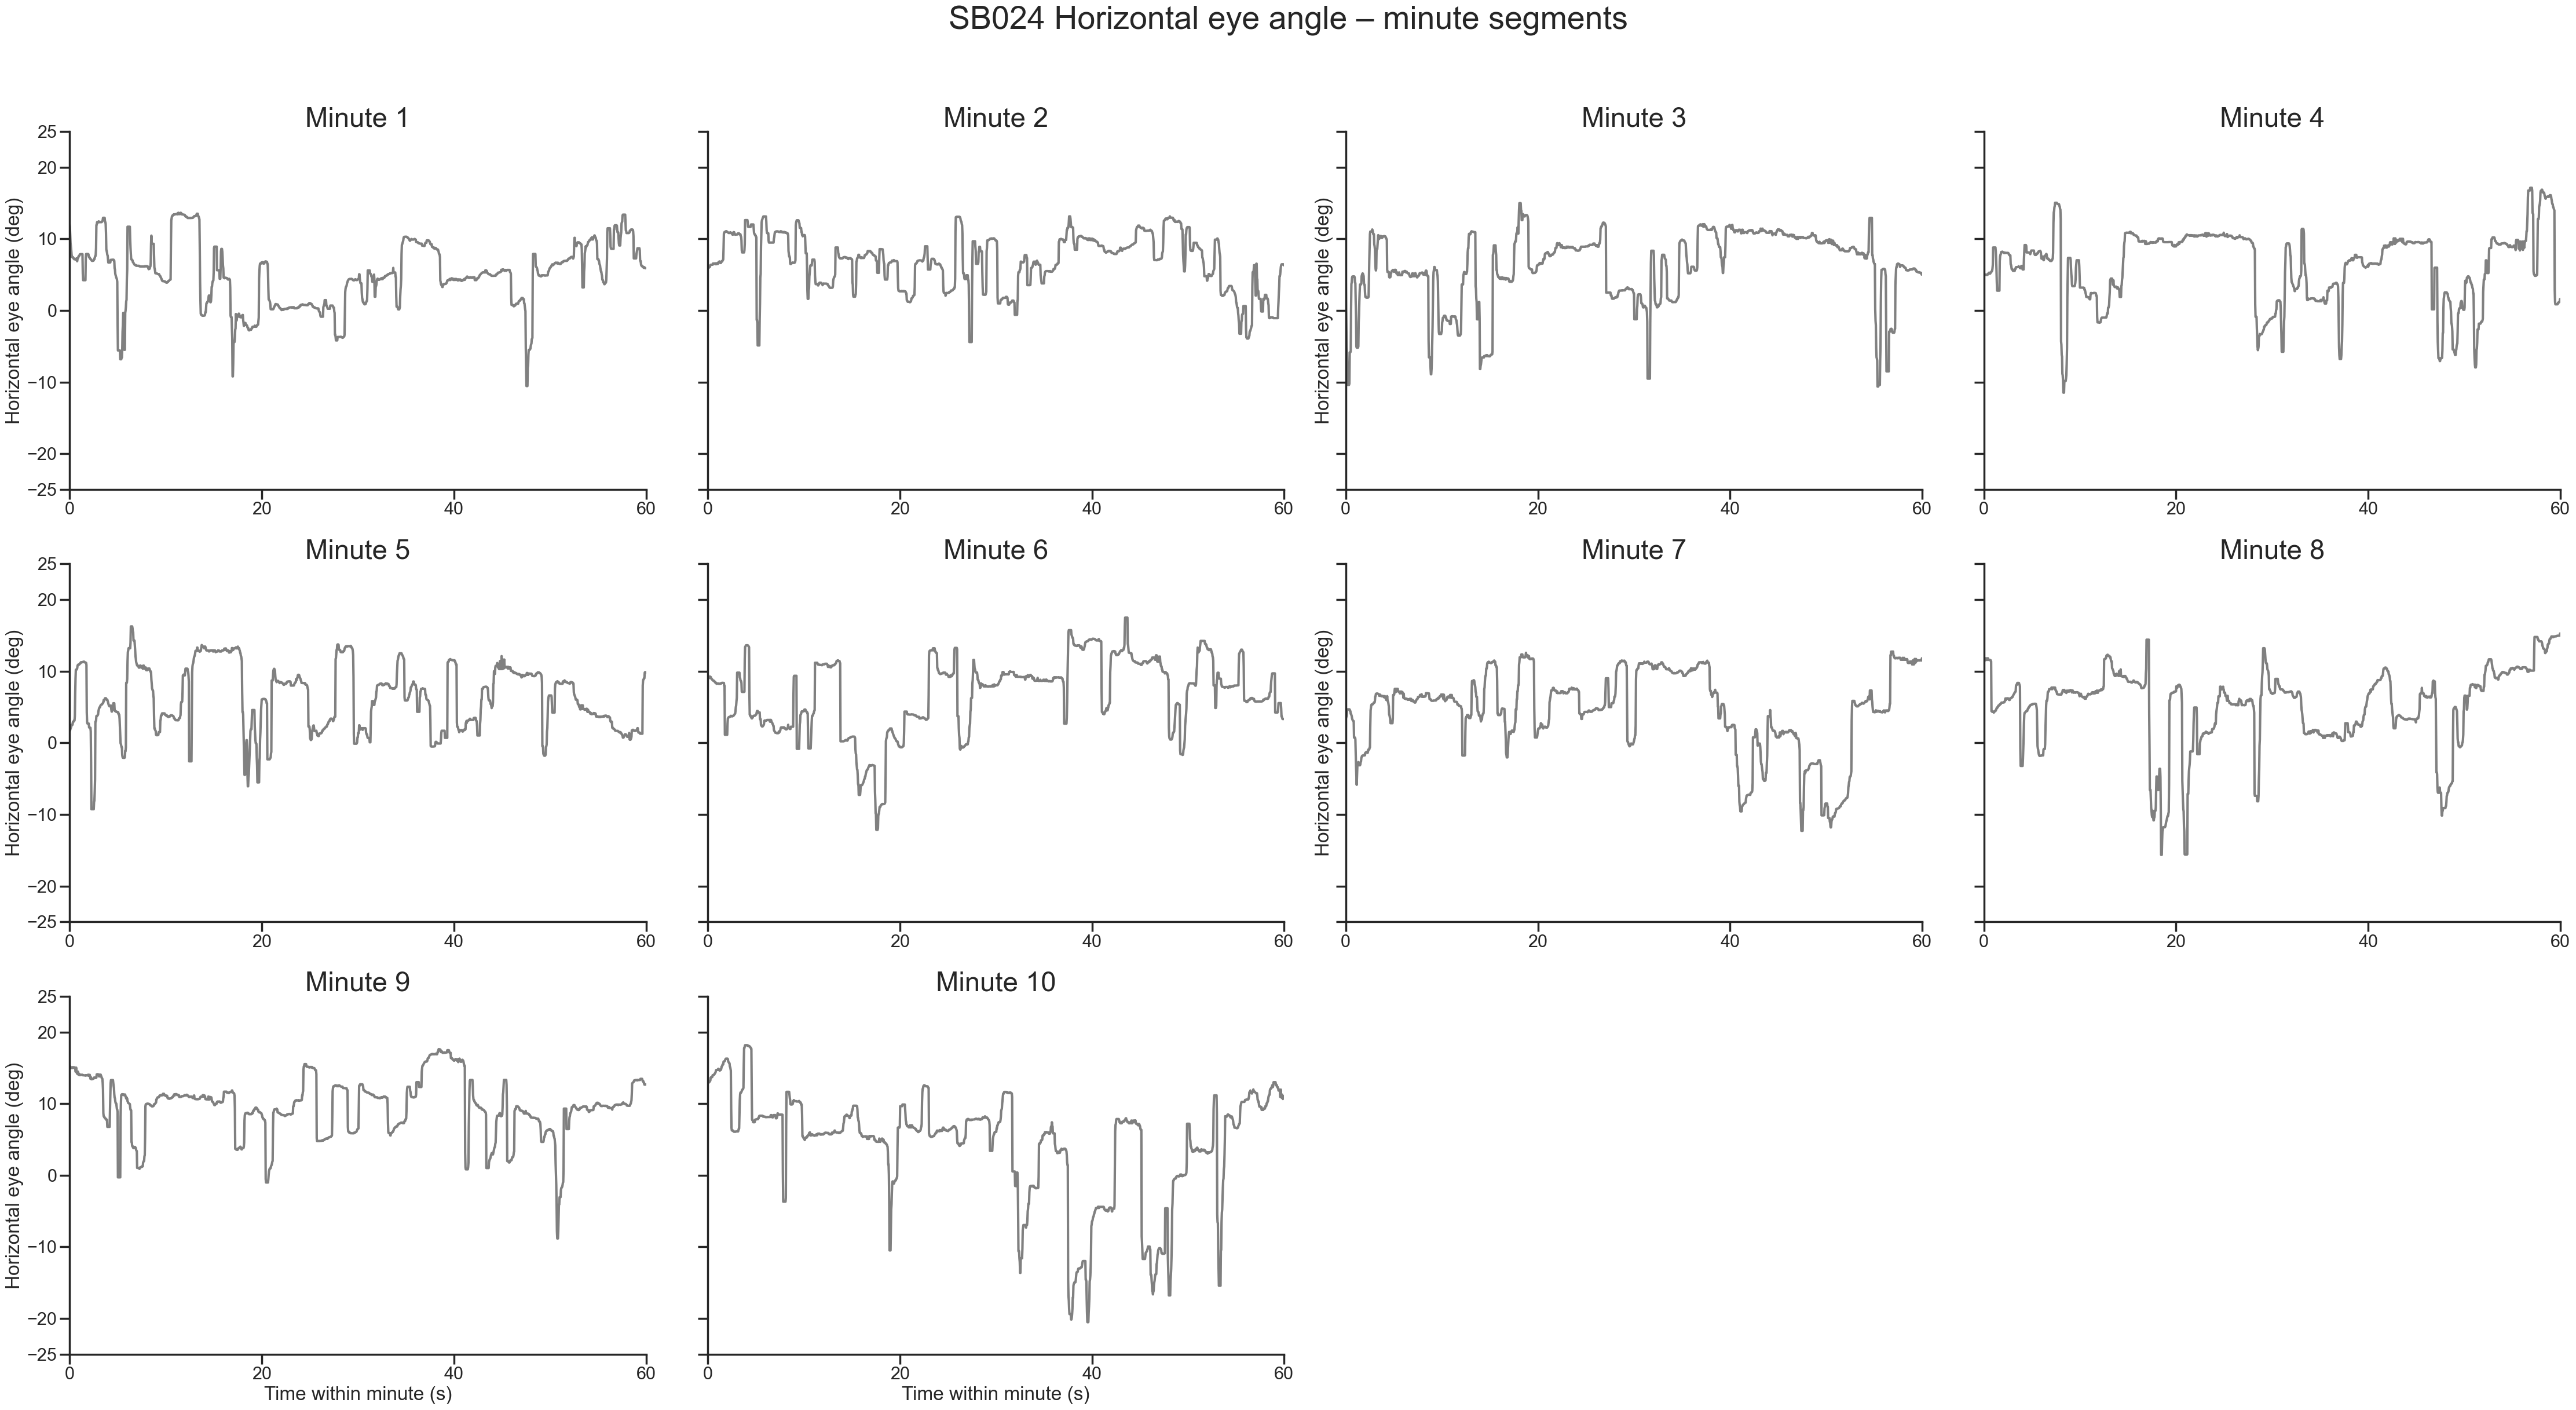

In [60]:
import cv2, numpy as np, matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# ------------------------------------------------------------------
# 1)  Input arrays --------------------------------------------------
# eye_h_deg  – your horizontal‑angle trace, shape (N,)
# If you followed the earlier steps:
#   eye_h_deg = ...   # already computed
#   video_path = ...  # path to the .mp4

cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
cap.release()
print(f'FPS = {fps:.2f}')

# ------------------------------------------------------------------
# 2)  Build the time axis (s) and slice by minute ------------------
t_sec = np.arange(len(eye_h_deg)) / fps
frames_per_min = int(round(fps * 60))          # integer frames in 60 s
n_panels       = 10                            # show first 10 min

# ------------------------------------------------------------------
# 3)  Plot grid  ----------------------------------------------------
fig, axes = plt.subplots(3, 4, figsize=(45, 25), sharey=True)
axes = axes.ravel()

sec_formatter = FuncFormatter(lambda x, pos: f'{int(x):02d} s')

for i in range(n_panels):
    f0      = i * frames_per_min
    f1      = f0 + frames_per_min
    ax      = axes[i]
    ax.plot(t_sec[f0:f1] - i*60, eye_h_smooth[f0:f1])
    ax.set_xlim(0, 60)
    ax.set_xticks([0, 20, 40, 60])
    ax.set_xticklabels(['0', '20', '40', '60'])
    ax.set_title(f'Minute {i+1}', fontsize=34)
    ax.set_ylim(-25, 25)
    ax.set_yticks([-25, -20, -10, 0, 10, 20, 25])
     # label only the leftmost column and bottom row to keep the grid tidy
    if i % 2 == 0:                      # left column
        ax.set_ylabel('Horizontal eye angle (deg)')
    if i >= n_panels - 2:               # bottom row of a 5×2 grid
        ax.set_xlabel('Time within minute (s)')

# tidy up
for ax in axes[n_panels:]:
    ax.axis('off')
    ax.grid(True)
fig.suptitle('SB024 Horizontal eye angle – minute segments', fontsize=40)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Frames selected: [1701, 3403, 5105, 6807, 8509, 10210, 11912, 13614, 15316, 17018]


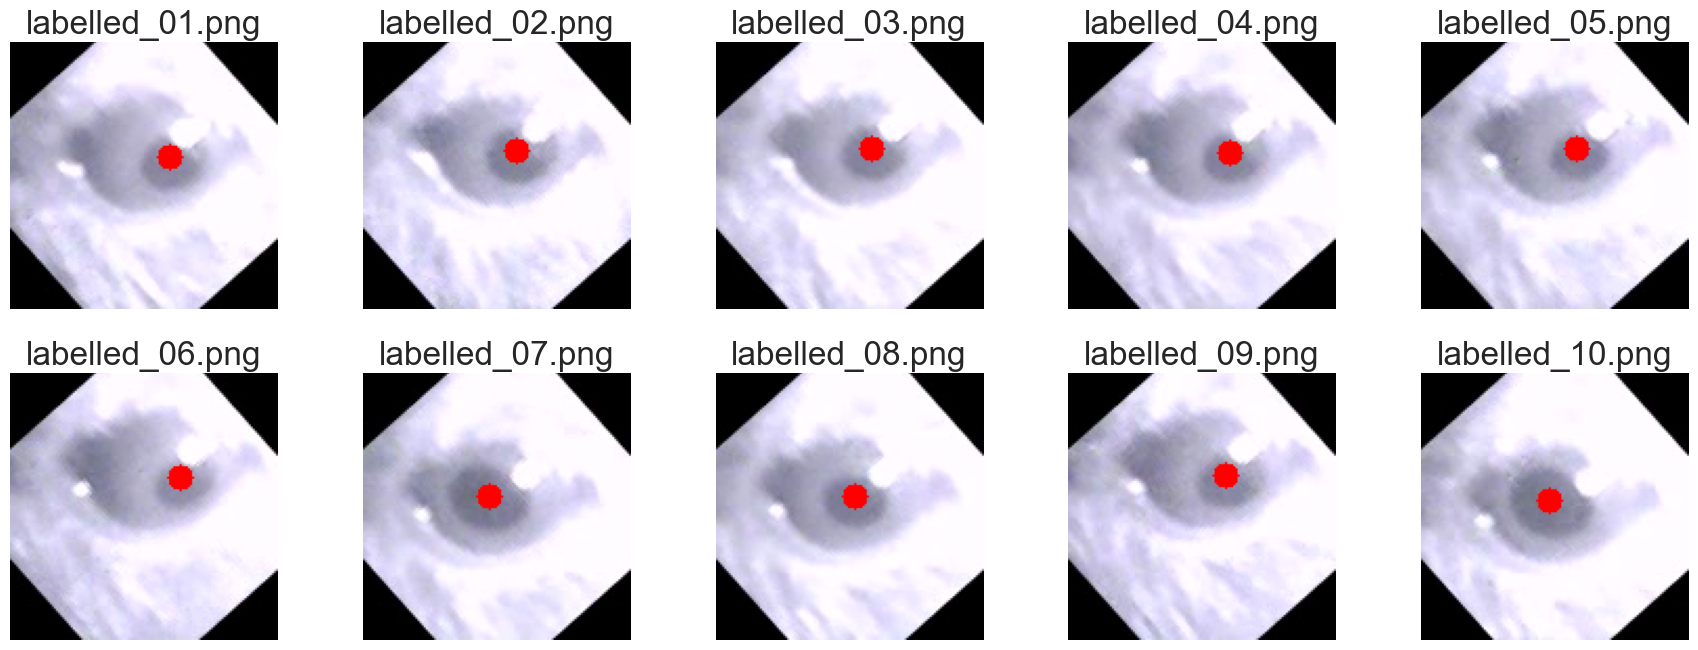

In [17]:
# ────────────────────────────────────────────────────────────────
# 0)  Paths  ––– EDIT THE TWO LINES BELOW ––––––––––––––––––––––––
h5_path    = dlc_path
# ────────────────────────────────────────────────────────────────

import cv2, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

# 1)  Load landmark table and flatten columns → "<bodypart>_<coord>"
df = pd.read_hdf(h5_path, key='df_with_missing')
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [f'{part}_{coord}' for (_, part, coord) in df.columns]

LABELS_PUPIL = ['north','ne','east','se','south','sw','west','nw']
xs = df[[f'{lb}_x' for lb in LABELS_PUPIL]].values
ys = df[[f'{lb}_y' for lb in LABELS_PUPIL]].values
pupil_centers = np.nanmean(np.stack([xs, ys], axis=-1), axis=1)  # (N,2)

# 2)  Choose 10 frames with finite centres, evenly spaced
valid_idx = np.where(~np.isnan(pupil_centers[:,0]))[0]
n_show    = 10
take_idx  = [valid_idx[math.floor(i*len(valid_idx)/(n_show+1))] for i in range(1, n_show+1)]

print('Frames selected:', take_idx)

# 3)  Open video and grab those frames
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise IOError(f'Cannot open {video_path}')

saved_paths = []
for j, f_idx in enumerate(take_idx, start=1):
    cap.set(cv2.CAP_PROP_POS_FRAMES, int(f_idx))
    ok, frame = cap.read()
    if not ok:
        print(f'⚠️  could not read frame {f_idx}')
        continue

    cx, cy = pupil_centers[f_idx]
    if not (np.isnan(cx) or np.isnan(cy)):
        cv2.circle(frame, (int(cx), int(cy)), 6, (0,0,255), -1)  # red dot

    outname = Path(video_path).with_name(f'labelled_{j:02d}.png')
    cv2.imwrite(str(outname), frame)
    saved_paths.append(outname)

cap.release()

# 4)  Display inline
fig, axes = plt.subplots(2,5, figsize=(18,7))
axes = axes.ravel()
for ax, img_p in zip(axes, saved_paths):
    ax.imshow(cv2.cvtColor(cv2.imread(str(img_p)), cv2.COLOR_BGR2RGB))
    ax.set_title(img_p.name); ax.axis('off')
plt.tight_layout()
plt.show()


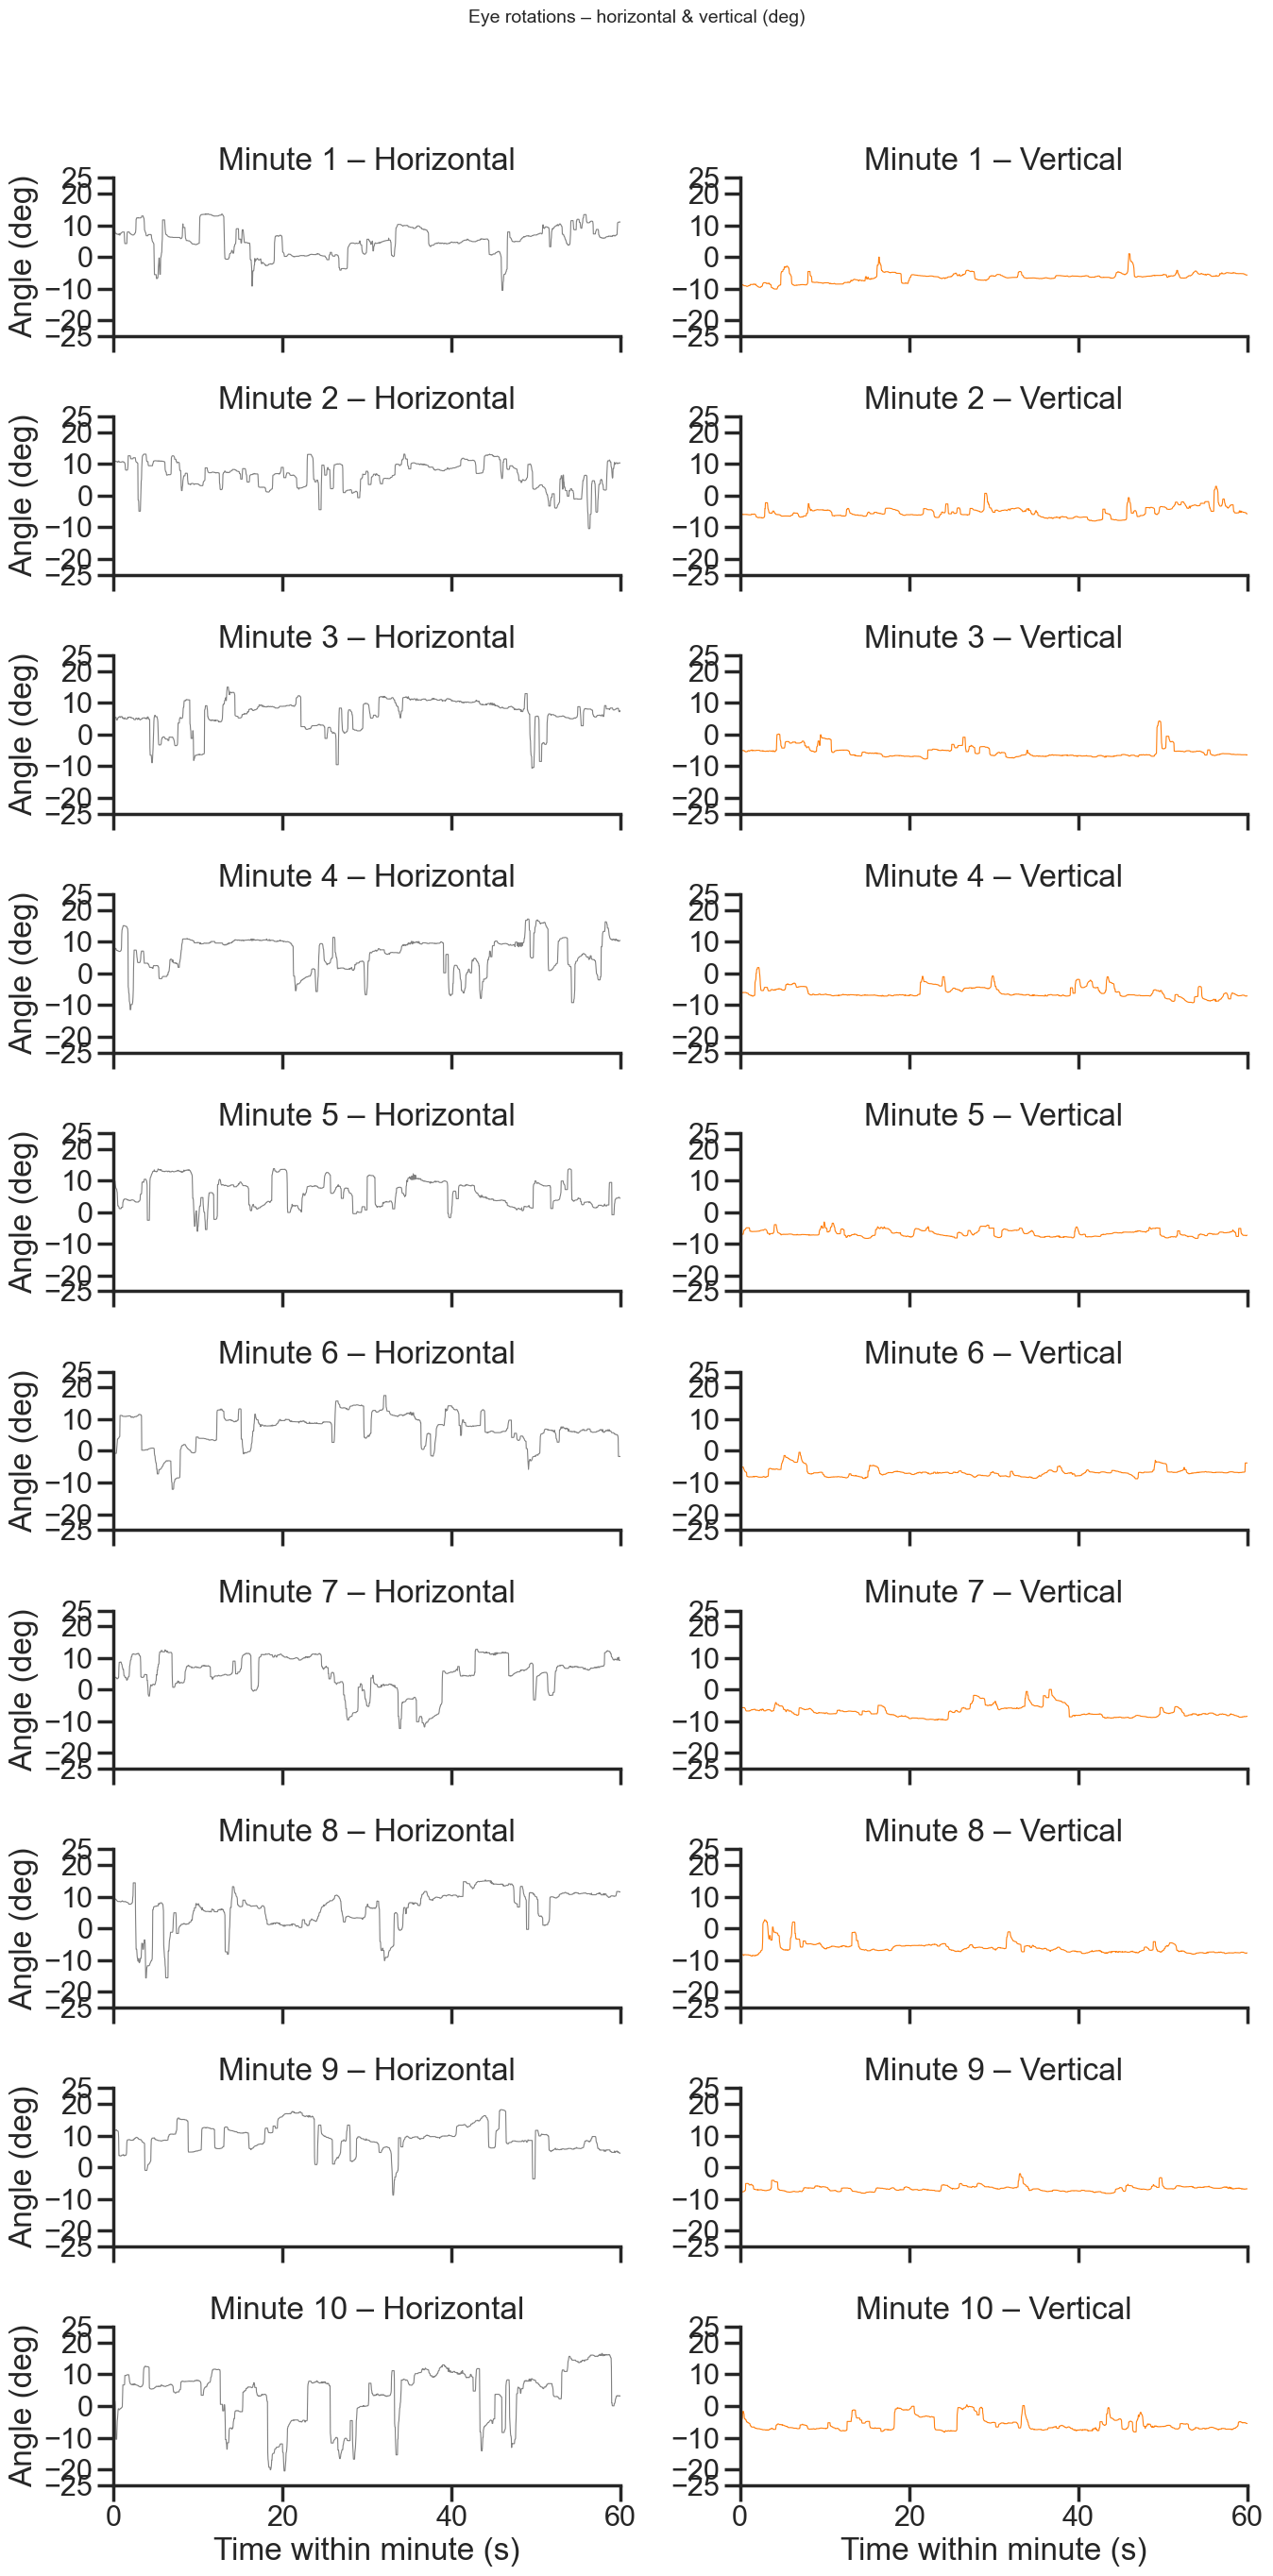

In [285]:
# ────────────────────────────────────────────────────────────────
# 0)  Prerequisites already defined earlier
#     pupil_centers  (N,2)   – x,y of pupil centre per frame
#     eye_centers    (N,2)   – x,y of eyeball centre per frame
#     eye_radii_px   (N,)    – eyeball radius per frame   (from circle fit)
#     EYE_RADIUS_MM  = 1.7
#     fps            = frame-rate  (float)
# ────────────────────────────────────────────────────────────────

import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import math, cv2

# ---------------------------------------------------------------
# 1)  PIXEL-SPACE displacement
dx_px = pupil_centers[:, 0] - eye_centers[:, 0]    # horizontal
dy_px = pupil_centers[:, 1] - eye_centers[:, 1]    # vertical  (+ = down on image)

# ---------------------------------------------------------------
# 2)  CALIBRATION  pixel → mm → deg
pix2mm        = EYE_RADIUS_MM / np.nanmedian(eye_radii_px)
dx_mm, dy_mm  = dx_px * pix2mm, dy_px * pix2mm

eye_h_deg = np.degrees(np.arcsin(np.clip( dx_mm / EYE_RADIUS_MM, -1, 1)))
eye_v_deg = np.degrees(np.arcsin(np.clip(-dy_mm / EYE_RADIUS_MM, -1, 1)))
#  note the minus ↑      ^ makes positive = upward rotation

# ---------------------------------------------------------------
# 3)  OPTIONAL smoothing (rolling median, 0.5 s window)
win_frames      = int(round(0.5 * fps)) | 1
eye_h_s = (pd.Series(eye_h_deg).rolling(win_frames, center=True,
                                        min_periods=1).median().values)
eye_v_s = (pd.Series(eye_v_deg).rolling(win_frames, center=True,
                                        min_periods=1).median().values)

# ---------------------------------------------------------------
# 4)  Minute-by-minute grid  (H & V together)
t_sec          = np.arange(len(eye_h_deg)) / fps
frames_per_min = int(round(fps * 60))
n_minutes      = math.floor(len(eye_h_deg) / frames_per_min)  # full minutes

fig, axes = plt.subplots(nrows=n_minutes, ncols=2,
                         figsize=(14, 2.8 * n_minutes), sharex='col')
if n_minutes == 1:                          # handle 1-row case
    axes = np.expand_dims(axes, axis=0)     # shape (1,2)

for i in range(n_minutes):
    f0, f1 = i * frames_per_min, (i + 1) * frames_per_min
    t_slice = t_sec[f0:f1] - i*60

    # --- horizontal panel (left column) ---
    ax_h = axes[i, 0]
    ax_h.plot(t_slice, eye_h_s[f0:f1], lw=0.8)
    ax_h.set_ylim(-25, 25)
    ax_h.set_yticks([-25, -20, -10, 0, 10, 20, 25])
    ax_h.set_xlim(0, 60)
    ax_h.set_xticks([0, 20, 40, 60])
    ax_h.set_title(f'Minute {i+1} – Horizontal')
    if i == n_minutes - 1:
        ax_h.set_xlabel('Time within minute (s)')
    ax_h.set_ylabel('Angle (deg)')

    # --- vertical panel (right column) ---
    ax_v = axes[i, 1]
    ax_v.plot(t_slice, eye_v_s[f0:f1], lw=0.8, color='tab:orange')
    ax_v.set_ylim(-25, 25)
    ax_v.set_yticks([-25, -20, -10, 0, 10, 20, 25])
    ax_v.set_xlim(0, 60)
    ax_v.set_xticks([0, 20, 40, 60])
    ax_v.set_title(f'Minute {i+1} – Vertical')
    if i == n_minutes - 1:
        ax_v.set_xlabel('Time within minute (s)')
    # y-labels on right column only if you prefer:
    # ax_v.set_ylabel('Angle (deg)')

fig.suptitle('Eye rotations – horizontal & vertical (deg)', fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
